## **Import Statements**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import random
import cv2
import os
import tensorflow as tf
from tqdm import tqdm

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.utils import plot_model
from keras import backend as K

from sklearn.model_selection import train_test_split

## **Data Loading**

In [2]:
good_frames = 'blur/sharp'
bad_frames = 'blur/defocused_blurred'

### **Clear Images**

In [3]:
clean_frames = []
for file in tqdm(sorted(os.listdir(good_frames))):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        image = tf.keras.preprocessing.image.load_img(good_frames + '/' + file, target_size=(128,128))
        image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
        clean_frames.append(image)

clean_frames = np.array(clean_frames)

100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [00:07<00:00, 45.68it/s]


### **Blurry Images**

In [4]:
blurry_frames = []
for file in tqdm(sorted(os.listdir(bad_frames))):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        image = tf.keras.preprocessing.image.load_img(bad_frames + '/' + file, target_size=(128,128))
        image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
        blurry_frames.append(image)

blurry_frames = np.array(blurry_frames)

100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [00:06<00:00, 52.14it/s]


## **Data Exploration**

### **Difference Between the Pixel Value Distributions of Clear and Blurry Images**

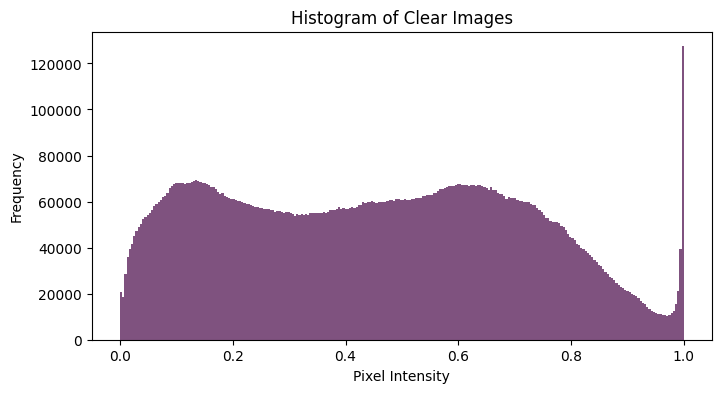

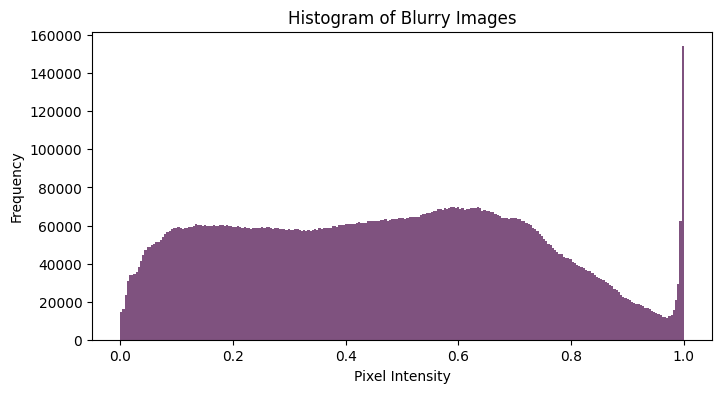

In [5]:
def plot_image_histogram(images, title):
    plt.figure(figsize=(8,4))
    plt.hist(images.ravel(), bins=256, color='orange', )
    plt.hist(images.ravel(), bins=256, color='blue', alpha=0.5)
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

plot_image_histogram(clean_frames, 'Histogram of Clear Images')
plot_image_histogram(blurry_frames, 'Histogram of Blurry Images')

### **Examples of Clear Images and their Corresponding Blurry Images**

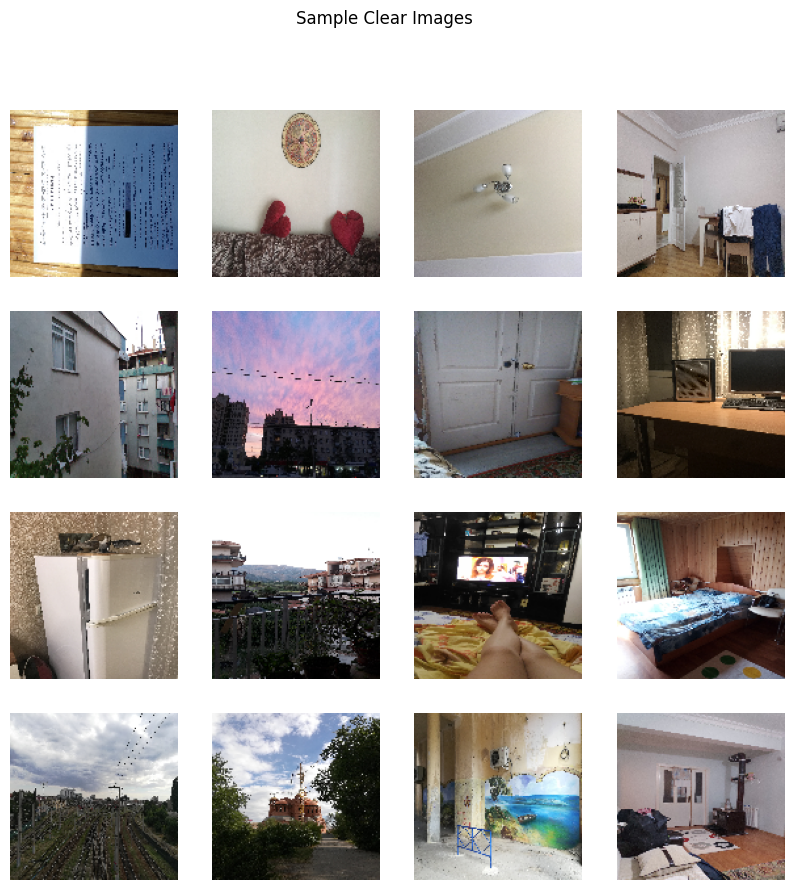

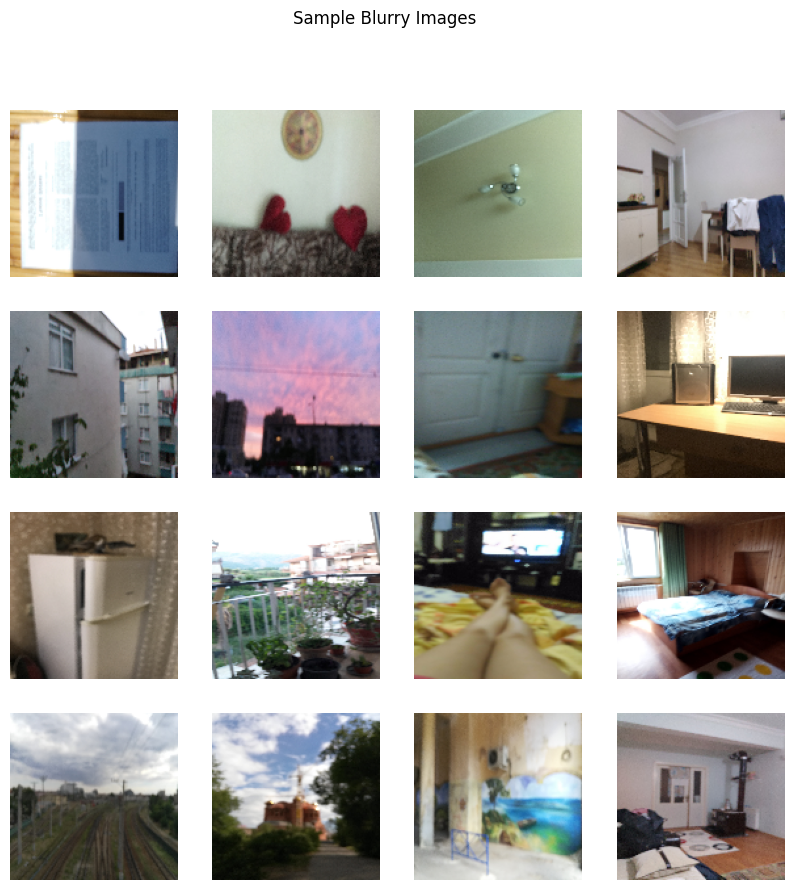

In [6]:
def plot_image_grid(images, title):
    plt.figure(figsize=(10, 10))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_image_grid(clean_frames, 'Sample Clear Images')
plot_image_grid(blurry_frames, 'Sample Blurry Images')

103


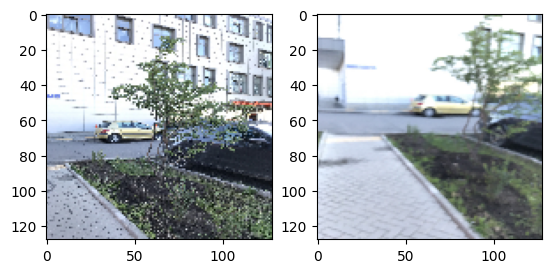

In [7]:
r = random.randint(0, len(clean_frames)-1)
print(r)
fig = plt.figure()
fig.subplots_adjust(hspace=0.1, wspace=0.2)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(clean_frames[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(blurry_frames[r])

## **Train-Test Split**

In [8]:
seed = 21
random.seed = seed
np.random.seed = seed

x = clean_frames;
y = blurry_frames;

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [9]:
print(x_train[0].shape)
print(y_train[0].shape)

(128, 128, 3)
(128, 128, 3)


## **Model Architecture**

### **Encoder Model Definition**

In [10]:
# Network Parameters
input_shape = (128, 128, 3)
batch_size = 32
kernel_size = 3
latent_dim = 256

# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

inputs = Input(shape = input_shape, name = 'encoder_input')
x = inputs

for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 latent_vector (Dense)       (None, 256)               16777472  
                                                                 
Total params: 17,148,288
Trainable params: 17,148,288
Non-t

### **Decoder Model Definition**

In [11]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)
                          
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 65536)             16842752  
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 128, 128, 64)     7379

### **Formation of the Complete Autoencoder by combining the Encoder and Decoders**

In [12]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 encoder (Functional)        (None, 256)               17148288  
                                                                 
 decoder (Functional)        (None, 128, 128, 3)       17803395  
                                                                 
Total params: 34,951,683
Trainable params: 34,951,683
Non-trainable params: 0
_________________________________________________________________


## **Model Training and Compilation**

### **Model Compilation with MSE loss, Adam Optimizer, and Learning Rate Decay(Reduce LR on Plateau)**

In [13]:
autoencoder.compile(loss='mse', optimizer='adam',metrics=["acc"])

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)
callbacks = [lr_reducer]

### **Model Training**

In [14]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam',metrics=["acc"])

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

callbacks = [lr_reducer]
history = autoencoder.fit(x_train,
                      y_train,
                      validation_data=(x_test, y_test),
                      epochs = 150,
                      batch_size=batch_size,
                      callbacks=callbacks,
                      verbose=2)        

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 encoder (Functional)        (None, 256)               17148288  
                                                                 
 decoder (Functional)        (None, 128, 128, 3)       17803395  
                                                                 
Total params: 34,951,683
Trainable params: 34,951,683
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
9/9 - 11s - loss: 0.0697 - acc: 0.6352 - val_loss: 0.0685 - val_acc: 0.6688 - lr: 0.0010 - 11s/epoch - 1s/step
Epoch 2/150
9/9 - 1s - loss: 0.0674 - acc: 0.6688 - val_loss: 0.0681 - val_acc: 0.6688 - lr: 0.0010 - 944ms/epoch - 105ms/step
Epoch 3/150
9/9 - 1s - loss: 0.0656 - acc: 0.6637 - val_l

## **Latent Space Representations Learned by the Encoder**

2/2 [==============================] - 0s 85ms/step


C:\Users\rithe\AppData\Local\Temp\ipykernel_26800\1750550245.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(latent_representations[:, 0], latent_representations[:, 1], c='blue', cmap='viridis')


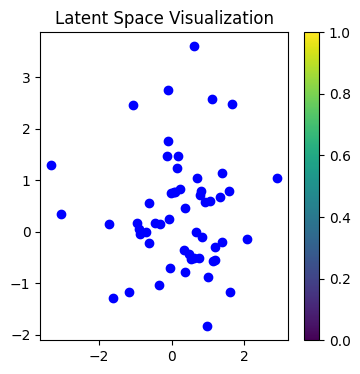

In [15]:
latent_representations = encoder.predict(x_test)
plt.figure(figsize=(4, 4))
plt.scatter(latent_representations[:, 0], latent_representations[:, 1], c='blue', cmap='viridis')
plt.colorbar()
plt.title('Latent Space Visualization')
plt.show()


       Input                                               Ground Truth                                 Predicted Value
1/1 [==============================] - 0s 30ms/step


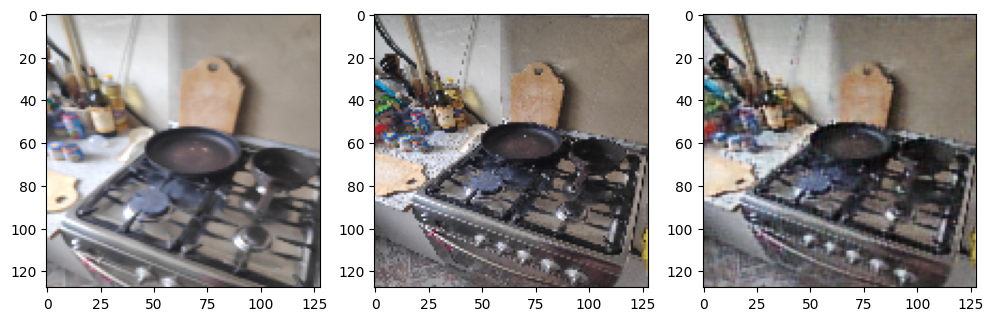

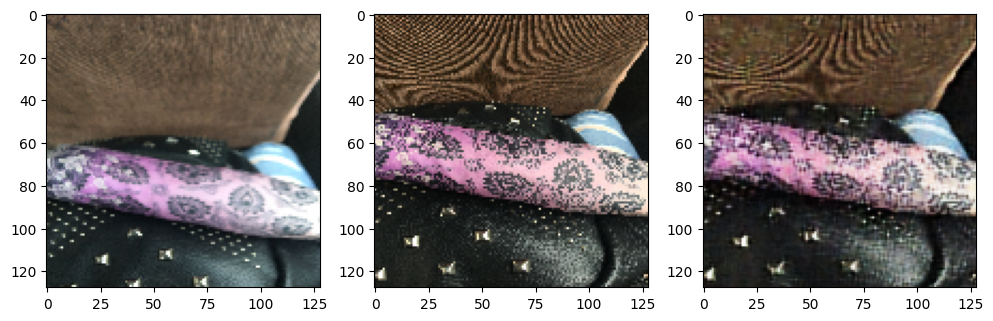

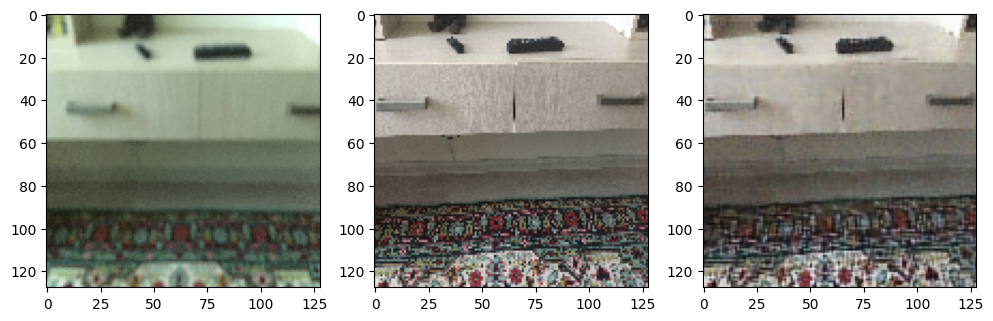

In [16]:
print("\n       Input                                               Ground Truth                                 Predicted Value")
for i in range(3):
    
    r = random.randint(0, len(clean_frames)-1)

    x, y = blurry_frames[r],clean_frames[r]
    x_inp=x.reshape(1,128,128,3)
    result = autoencoder.predict(x_inp)
    result = result.reshape(128,128,3)

    fig = plt.figure(figsize=(12,10))
    fig.subplots_adjust(hspace=0.1, wspace=0.2)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x)

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(y)

    ax = fig.add_subplot(1, 3, 3)
    plt.imshow(result)

1/1 [==============================] - 0s 22ms/step
Flag: 274



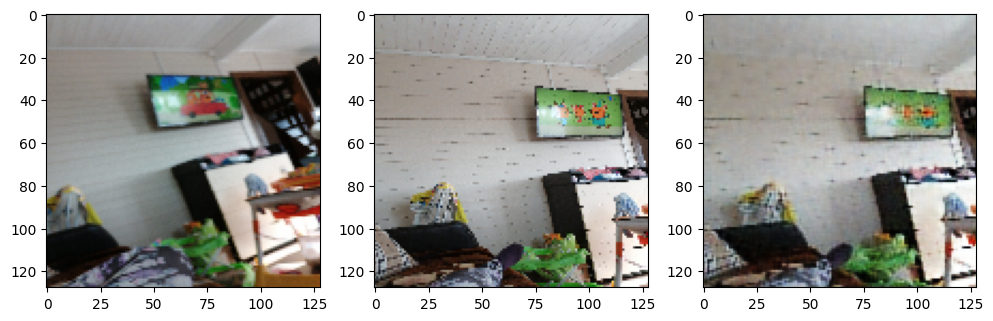

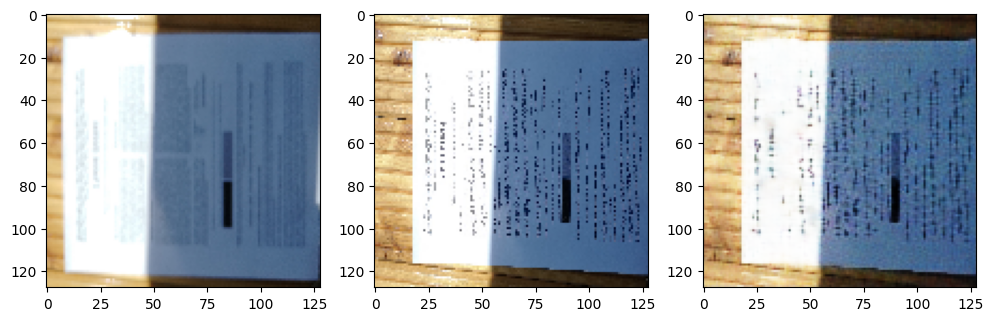

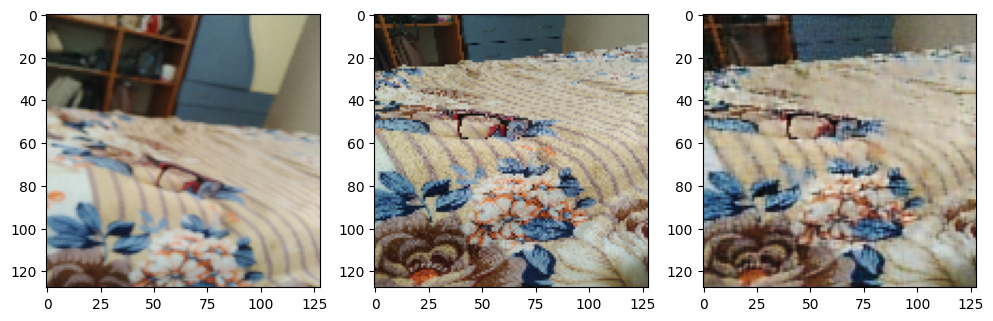

In [17]:
for i in range(3):
    
    r = random.randint(0, len(clean_frames)-1)

    x, y = blurry_frames[r],clean_frames[r]
    x_inp=x.reshape(1,128,128,3)
    result = autoencoder.predict(x_inp)
    result = result.reshape(128,128,3)

    fig = plt.figure(figsize=(12,10))
    fig.subplots_adjust(hspace=0.1, wspace=0.2)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x)

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(y)

    ax = fig.add_subplot(1, 3, 3)
    plt.imshow(result)
print("Flag:", len(clean_frames))
print()

## **Training and Validation Loss Curves**

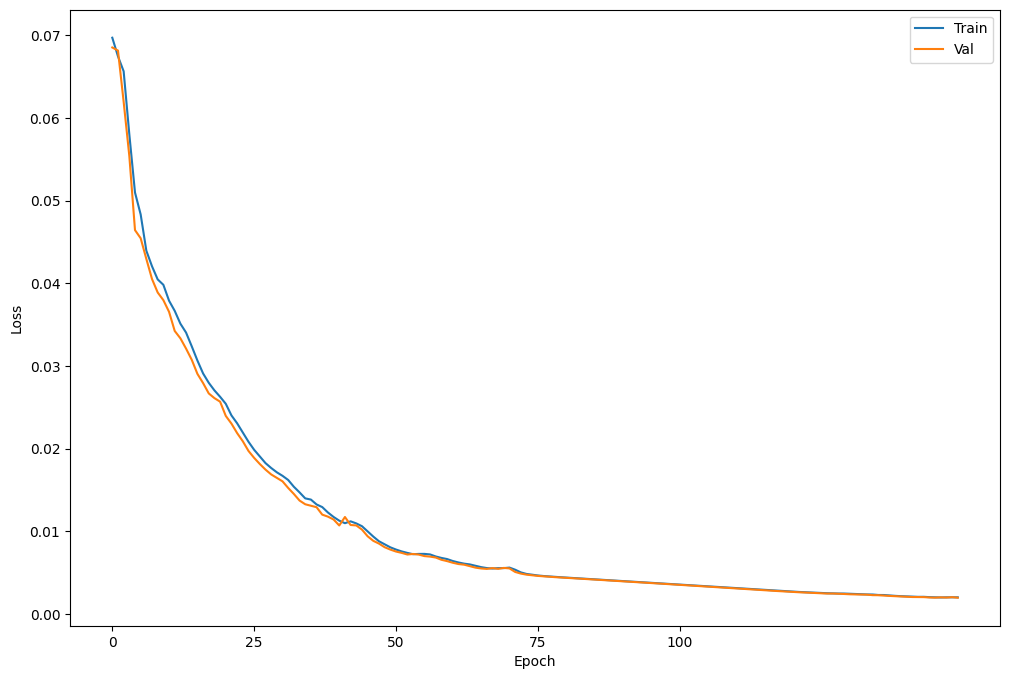

In [18]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(0, 101, 25))
plt.show()

## **Training and Validation Accuracy Curves**

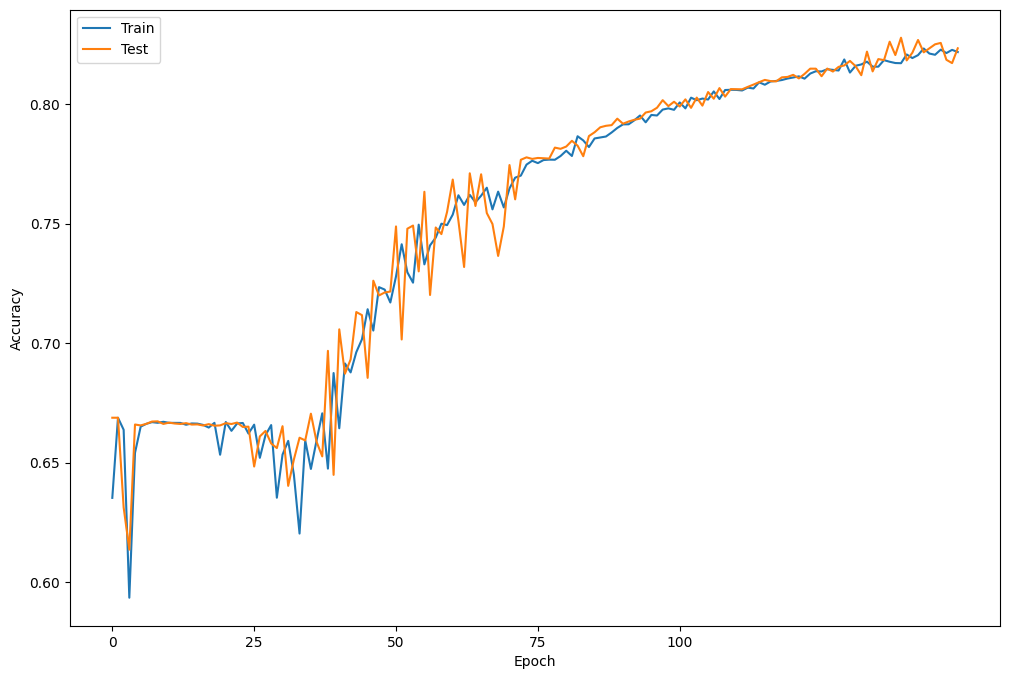

In [19]:
plt.figure(figsize=(12,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, 101, 25))
plt.show()

## **Model Evaluation with Advanced Performace Metrics(PSNR and SSIM)**

In [20]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def evaluate_model_performance(x_test, y_test, model):
    psnr_values = []
    ssim_values = []
    for i in range(len(x_test)):
        clean_image = y_test[i]
        blurry_image = x_test[i].reshape(1, 128, 128, 3)
        predicted_image = model.predict(blurry_image).reshape(128, 128, 3)
        
        psnr_value = peak_signal_noise_ratio(clean_image, predicted_image, data_range=1.0)
        ssim_value = structural_similarity(clean_image, predicted_image, win_size=7, channel_axis=2, data_range=1.0)
        
        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)
    return avg_psnr, avg_ssim

avg_psnr, avg_ssim = evaluate_model_performance(x_test, y_test, autoencoder)
print(f"Average PSNR: {avg_psnr:.2f}")
print(f"Average SSIM: {avg_ssim:.2f}")

1/1 [==============================] - 0s 15ms/step
Average PSNR: 13.96
Average SSIM: 0.26


In [ ]:
# Save the trained model
autoencoder.save('autoencoder_model_h5/autoencoder_model.h5')